In [ ]:
import pyspark
import time
print(pyspark.__version__)
start_time = time.time()

3.4.1


In [29]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import matplotlib
# 设置全局中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常

spark = SparkSession.builder.appName("DataAnalysis")\
    .config("spark.default.parallelism", 4) \
    .config("spark.driver.memory", "16g")\
    .config("spark.executor.memory", "16g")\
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate() 
    
base_path = "30G_data_new/part-"
file_path = [f"{base_path}{str(i).zfill(5)}.parquet" for i in range(16)]
df = spark.read.parquet(*file_path)

df.printSchema()
df.show(5, truncate=False)

root
 |-- id: long (nullable = true)
 |-- last_login: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- email: string (nullable = true)
 |-- age: long (nullable = true)
 |-- income: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- country: string (nullable = true)
 |-- address: string (nullable = true)
 |-- purchase_history: string (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- login_history: string (nullable = true)

+---+-------------------------+----------+--------+------------------+---+---------+------+-------+-------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------+-----------------+------------------

# ​年龄分布直方图

<Axes: xlabel='age_group', ylabel='count'>

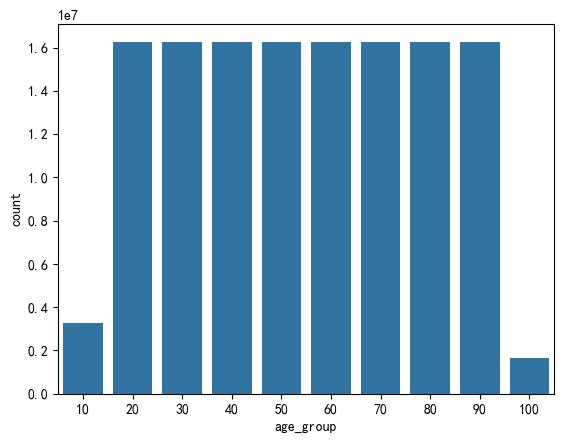

In [30]:
import seaborn as sns
import pyspark.sql.functions as F
age_dist = df.groupBy(
    (F.floor(F.col('age')/10)*10).alias('age_group')
).count().orderBy('age_group').toPandas()
sns.barplot(x='age_group', y='count', data=age_dist)

In [31]:
print("filter error age: now count:" + str(df.count()))
df = df.filter((F.col('age') >= 0) & (F.col('age') <= 120))
print("after filter count: " + str(df.count()))

filter error age: now count:135000000
after filter count: 135000000


# 性别-国家交叉热力图

<Axes: ylabel='gender'>

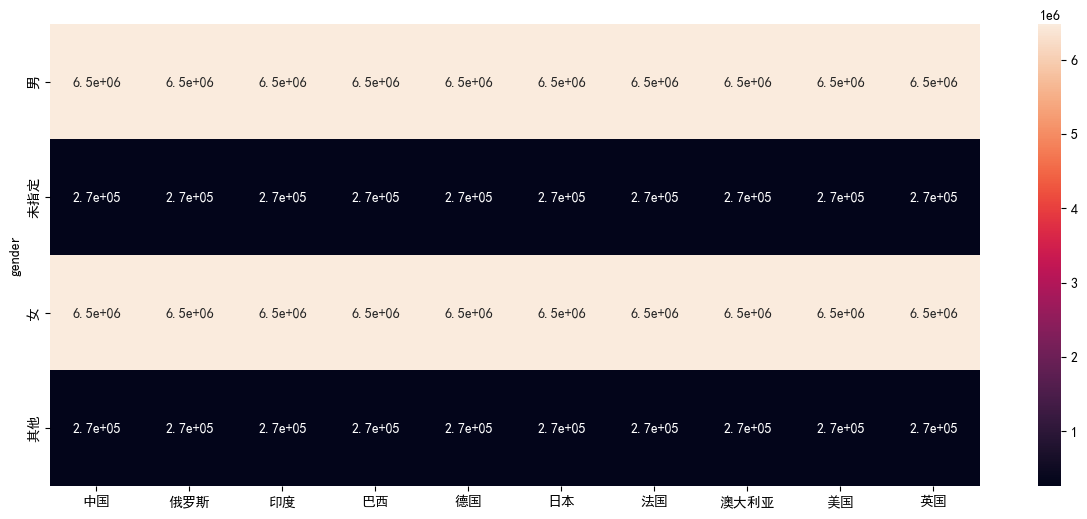

In [32]:
import matplotlib.pyplot as plt
import matplotlib
# 设置全局中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常

cross_tab = df.groupBy('gender').pivot('country').count().fillna(0)
plt.figure(figsize=(15,6))
sns.heatmap(cross_tab.toPandas().set_index('gender'), annot=True)

In [33]:
import pyspark.sql.functions as F
# 检查缺失值
missing_values = {}
for col_name in df.columns:
    missing_count = df.filter(F.col(col_name).isNull()).count()
    missing_ratio = missing_count / df.count()
    missing_values[col_name] = (missing_count, missing_ratio)
print("缺失值统计：")
for col_name, (count, ratio) in missing_values.items():
    print(f"{col_name}: 数量={count}, 比例={ratio:.2%}")

缺失值统计：
id: 数量=0, 比例=0.00%
last_login: 数量=0, 比例=0.00%
user_name: 数量=0, 比例=0.00%
fullname: 数量=0, 比例=0.00%
email: 数量=0, 比例=0.00%
age: 数量=0, 比例=0.00%
income: 数量=0, 比例=0.00%
gender: 数量=0, 比例=0.00%
country: 数量=0, 比例=0.00%
address: 数量=0, 比例=0.00%
purchase_history: 数量=0, 比例=0.00%
is_active: 数量=0, 比例=0.00%
registration_date: 数量=0, 比例=0.00%
phone_number: 数量=0, 比例=0.00%
login_history: 数量=0, 比例=0.00%


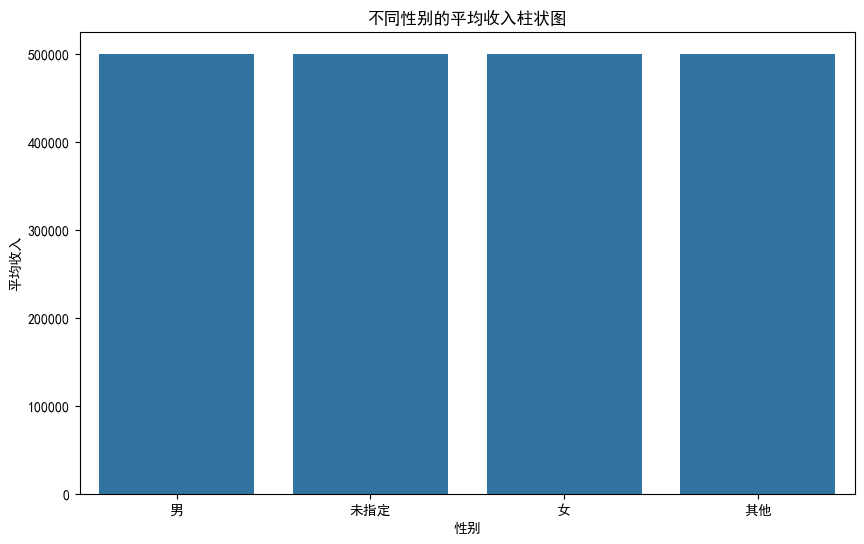

In [34]:
import seaborn as sns
# 2. 不同性别的平均收入柱状图
gender_income = df.groupBy("gender").avg("income").toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="gender", y="avg(income)", data=gender_income)
plt.title("不同性别的平均收入柱状图")
plt.xlabel("性别")
plt.ylabel("平均收入")
plt.show()

In [35]:
from pyspark.sql.functions import col, from_json, explode, when, size, avg, count
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, IntegerType
import seaborn as sns
# 定义 JSON 结构
purchase_schema = StructType([
    StructField("avg_price", FloatType(), True),
    StructField("categories", StringType(), True),
    StructField("items", ArrayType(StructType([
        StructField("id", IntegerType(), True)
    ])), True)
])

# 解析 purchase_history 列
df = df.withColumn(
    "purchase_detail",
    from_json(col("purchase_history"), purchase_schema)
).select(
    "*",
    col("purchase_detail.avg_price").alias("purchase_avg_price"),
    col("purchase_detail.categories").alias("purchase_category"),
    col("purchase_detail.items").alias("purchase_items")
)

# 计算购买商品数量
df = df.withColumn("purchase_item_count", size(col("purchase_items")))

# 年龄分层
df = df.withColumn("age_group",
                   when(col("age") < 30, "青年")
                   .when((col("age") >= 30) & (col("age") < 60), "中年")
                   .when(col("age") >= 60, "老年")
                   )

# 收入分层
df = df.withColumn("income_group",
                   when(col("income") < 100000, "低收入")
                   .when((col("income") >= 100000) & (col("income") < 500000), "中等收入")
                   .when(col("income") >= 500000, "高收入")
                   )

# 提取用户画像
user_profile = df.select("user_name", "age_group", "income_group", "gender", "country",
                         "purchase_category", "purchase_avg_price", "purchase_item_count")
user_profile.show()


+----------+---------+------------+------+-------+-----------------+------------------+-------------------+
| user_name|age_group|income_group|gender|country|purchase_category|purchase_avg_price|purchase_item_count|
+----------+---------+------------+------+-------+-----------------+------------------+-------------------+
|OFVIUGZMWH|     老年|      低收入|    女|   日本|             文具|            4041.0|                  3|
|    KMLBNE|     中年|    中等收入|    男|   美国|             鞋子|            3608.0|                  5|
|   NGTSMVK|     老年|    中等收入|    男|   日本|             文具|            6416.0|                  2|
|    IJLZVS|     老年|    中等收入|    男|   印度|         办公用品|            8157.0|                  2|
|     XCLES|     老年|      高收入|    女|   英国|         户外装备|            1626.0|                  5|
|  MWSYLTFS|     老年|      高收入|    男|   巴西|         车载电子|            4286.0|                  4|
|XMOXOUVBLG|     中年|    中等收入|    男|   印度|             蔬菜|            1864.0|                  2|


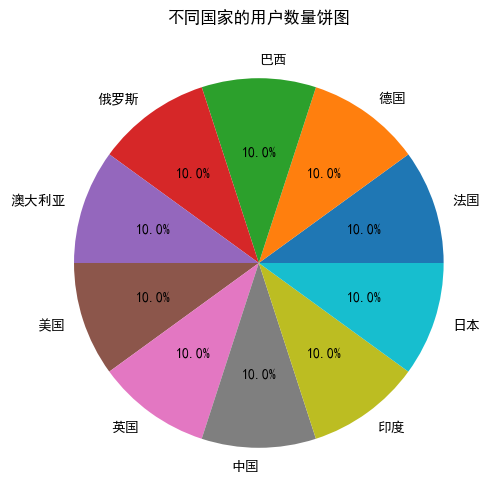

In [36]:
# 3. 不同国家的用户数量饼图
country_count = df.groupBy("country").count().toPandas()
plt.figure(figsize=(10, 6))
plt.pie(country_count["count"], labels=country_count["country"], autopct='%1.1f%%')
plt.title("不同国家的用户数量饼图")
plt.show()

In [37]:
purchase_hist = df.select('purchase_history')
purchase_hist.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|purchase_history                                                                                                                                                                               |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"avg_price":4041,"categories":"文具","items":[{"id":8852},{"id":2079},{"id":5043}],"payment_method":"微信支付","payment_status":"部分退款","purchase_date":"2021-09-30"}                      |
|{"avg_price":3608,"categories":"鞋子","items":[{"id":1584},{"id":8242},{"id":3209},{"id":3135},{"id":9768}],"payment_method":"微信支付","payment_status":"已退款","purchase_date":"2025-02-18"}|
|{"avg_price":6416,"categories":"文具","items":[{"i

In [38]:
import matplotlib.pyplot as plt
import matplotlib
# 将 purchase_history 列从字符串解析为 JSON 格式
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, IntegerType


# 定义 JSON 结构
schema = StructType([
    StructField("avg_price", FloatType(), True),
    StructField("categories", StringType(), True),
    StructField("items", ArrayType(StructType([
        StructField("id", IntegerType(), True)
    ])), True)
])

df_hist = df.select('id', 'purchase_history')
df_hist = df_hist.withColumn("purchase_history", from_json(F.col("purchase_history"), schema))

exploded_df = df_hist.select(F.col("id"), F.col("purchase_history.avg_price"), F.col("purchase_history.categories"), F.explode(F.col("purchase_history.items")).alias("item"))

# 提取 item 中的 id
final_df = exploded_df.select(F.col("id"), F.col("avg_price"), F.col("categories"), F.col("item.id").alias("item_id"))

final_df.show()

+---+---------+----------+-------+
| id|avg_price|categories|item_id|
+---+---------+----------+-------+
|  0|   4041.0|      文具|   8852|
|  0|   4041.0|      文具|   2079|
|  0|   4041.0|      文具|   5043|
|  1|   3608.0|      鞋子|   1584|
|  1|   3608.0|      鞋子|   8242|
|  1|   3608.0|      鞋子|   3209|
|  1|   3608.0|      鞋子|   3135|
|  1|   3608.0|      鞋子|   9768|
|  2|   6416.0|      文具|   6423|
|  2|   6416.0|      文具|    124|
|  3|   8157.0|  办公用品|   7720|
|  3|   8157.0|  办公用品|   3795|
|  4|   1626.0|  户外装备|   8249|
|  4|   1626.0|  户外装备|   2809|
|  4|   1626.0|  户外装备|   7562|
|  4|   1626.0|  户外装备|    803|
|  4|   1626.0|  户外装备|   2963|
|  5|   4286.0|  车载电子|   8469|
|  5|   4286.0|  车载电子|   3339|
|  5|   4286.0|  车载电子|   5786|
+---+---------+----------+-------+
only showing top 20 rows



In [40]:
from pyspark.sql.functions import avg, count

# 计算每个类别的平均价格
category_avg_price = final_df.groupBy("categories") \
    .agg(avg("avg_price").alias("avg_price"))

category_avg_price.show()

# 计算每个类别下的商品数量
category_item_count = final_df.groupBy("categories") \
    .agg(count("item_id").alias("item_count"))

category_item_count.show()

+------------+-----------------+
|  categories|        avg_price|
+------------+-----------------+
|        手套|5002.455359432832|
|      摄像机|5006.667414865964|
|    益智玩具|5004.741473632014|
|    床上用品|5004.956483324512|
|        肉类|5006.180433022654|
|        水产|5003.769473132998|
|儿童课外读物|5004.670701980807|
|        围巾|5005.367968031681|
|    平板电脑| 5005.63985019901|
|        米面|5004.291857787349|
|        蛋奶|5004.164575206713|
|        上衣| 5005.28868863666|
|        内衣|5003.854262382573|
|    车载电子|5003.282634875896|
|        模型|5004.559572653083|
|        外套| 5005.35775783855|
|        鞋子|5003.363729989586|
|    汽车装饰|5004.001003354672|
|        饮料|5006.729457247068|
|        水果|5003.961183580717|
+------------+-----------------+
only showing top 20 rows

+------------+----------+
|  categories|item_count|
+------------+----------+
|        手套|   9634387|
|      摄像机|   9640034|
|    益智玩具|   9647836|
|    床上用品|   9637409|
|        肉类|   9638341|
|        水产|   9638087|
|儿童课外读物|   9642785|


In [41]:
spark.catalog.clearCache()

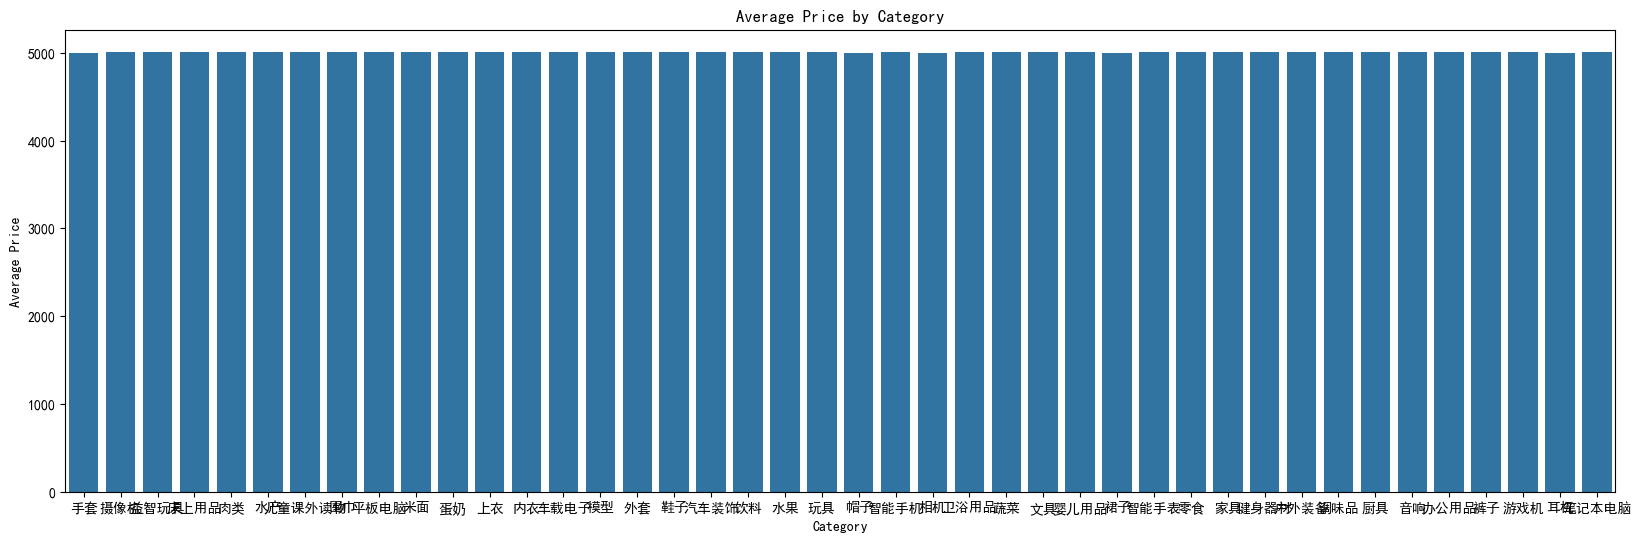

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 将结果转换为 Pandas DataFrame
category_avg_price_pd = category_avg_price.toPandas()

# 绘制柱状图
plt.figure(figsize=(20,6))
sns.barplot(x="categories", y="avg_price", data=category_avg_price_pd)
plt.xlabel("Category")
plt.ylabel("Average Price")
plt.title("Average Price by Category")
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"程序运行时间: {elapsed_time} 秒")